# Analyse the SSNAP data

Descriptive analysis of the formatted SSNAP dataset.

Dataset includes the patient cohort to make decision about thrombolysis:
* ischaemic patients
* have either/neither/both thrombolysis/thrombectomy.
* Not on anticoagulants.
* Arrive at hospital by ambulance.
* Have scan within 255 mins of stroke onset.

Calculate the thrombolysis rates for subgroups of patients: different stroke severity, prior disability and discharge disability.

## Import libraries

In [29]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass

import time

Report the time duration to run notebook

In [30]:
start_time = time.time()

In [31]:
surrogate_time_for_no_thrombolysis = 9999

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [32]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    data_read_path: str = '../data_processing/output'
    data_read_filename: str = '02_reformatted_data_ml_include_mt_remove_anticoag.csv'
    notebook: str = '000_'
    model_text: str = 'ssnap_descriptive_stats'

paths = Paths()

## Import data

Import the formatted SSNAP dataset.

In [33]:
filename = os.path.join(paths.data_read_path, paths.data_read_filename)
data = pd.read_csv(filename)

In [34]:
data.shape

(78396, 57)

In [35]:
class_names = data['discharge_disability'].unique()
class_names = np.sort(class_names)
n_classes = len(class_names)
print(f'There are {n_classes} classes in the target feature')

There are 7 classes in the target feature


Get list of features

In [36]:
features = list(data)
print(f"There are {len(features)} features")

There are 57 features


# Define data types for features

In [37]:
feature_types = {
    'prior_disability': 'int',
    'stroke_severity': 'int',
    'stroke_team_id': 'category',
    'onset_to_thrombolysis': 'int',
    'age': 'float',
    'discharge_disability': 'category',
    'stroke_team': 'category'
}

### Calculate admissions, thrombolysis rates (per hospital, and per patient subgroups).

The receive thrombolysis feature is included in the dataset in the new feature onset_to_thrombolysis_time (if a patient receives thrombolysis the duration is stored, else store -100).

Create a temporary dataframe that contains the necessary data for this part of the analysis (a row per patient, five columns: Stroke team, Prior disability, discharge disability, stroke severity, receive thrombolysis)

In [38]:
data.groupby(by=["stroke_team"])["stroke_team"].count().describe()

count     111.000000
mean      706.270270
std       257.983719
min       267.000000
25%       515.500000
50%       677.000000
75%       860.000000
max      1414.000000
Name: stroke_team, dtype: float64

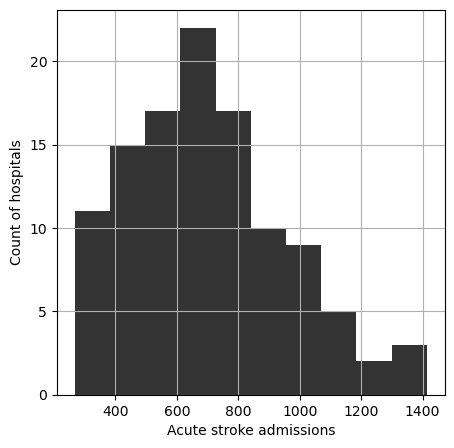

In [39]:
ax = data.groupby(by=["stroke_team"])["stroke_team"].count().hist(
                                color='k', alpha = 0.8, figsize=(5,5))

ax.set(xlabel="Acute stroke admissions", ylabel="Count of hospitals")

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_admissions_hist.jpg'))

plt.savefig(filename, dpi=300)

In [40]:
# store necessary data in a temporary dataframe
columns = ["stroke_team", "prior_disability", "discharge_disability", 
           "stroke_severity"]

df_subdata = pd.DataFrame(data=data[columns], columns=columns)

mask = data['onset_to_thrombolysis_time'] != surrogate_time_for_no_thrombolysis
df_subdata["Thrombolysis"] = mask

Calculate thrombolysis rate per hospital

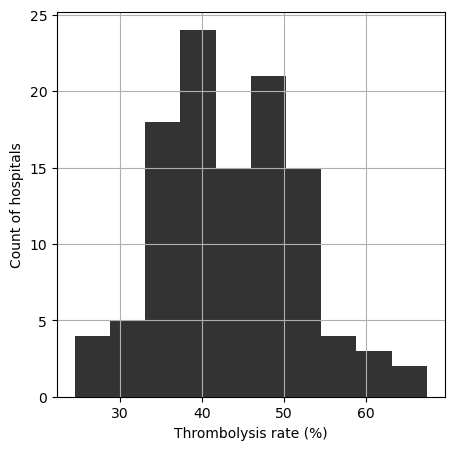

In [41]:
hosp_ivt_rate = (df_subdata.groupby(by=["stroke_team"]).mean()["Thrombolysis"])*100
ax = hosp_ivt_rate.hist(color='k', alpha = 0.8, figsize=(5,5))
ax.set(xlabel="Thrombolysis rate (%)", ylabel="Count of hospitals")

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_thrombolysis_rate_hist.jpg'))

plt.savefig(filename, dpi=300)

In [42]:
hosp_ivt_rate.min()

24.41717791411043

In [43]:
hosp_ivt_rate.max()

67.49174917491749

The following sections will look at the proportion of patients that are given thrombolysis, grouped by a characteristic:

1. Prior disability
1. Discharge disability
1. Stroke severity

First, define function to be used in each of those sections

In [44]:
data["stroke_team"].nunique()

111

## Define functions use in the following sections

Define function to create dataframe

In [45]:
def create_groupby_dataframe(df, by_feature_name):
    """
    df (dataframe):
    feature_name (string): feature to group data on
    """

    df_result = pd.DataFrame()
    df_result["Total patients"] = (
                df.groupby(by=[by_feature_name]).count()["Thrombolysis"])
    df_result["Count get IVT"] = (
                df.groupby(by=[by_feature_name]).sum()["Thrombolysis"])
    df_result["Count not get IVT"] = (
                df_result["Total patients"] - df_result["Count get IVT"])
    df_result["Proportion get IVT"] = (
                df.groupby(by=[by_feature_name]).mean()["Thrombolysis"])
    
    return(df_result)

Define function to create piechart

In [46]:
def create_piechart(df, labels, colors):
    """
    df (dataframe)
    mylabel (list)
    colors (list)
    """
    # initialise list to contain counts of patients
    list_results = []
    list_results.extend(df["Count get IVT"])
    list_results.extend(df["Count not get IVT"])

    myexplode = [0.01] * len(labels)

    # plot the piechart
    plt.pie(list_results, labels=labels, explode=myexplode, 
            rotatelabels = 270, textprops={'fontsize': 8}, colors=colors)

    # add a circle at the center to transform it in a donut chart
    my_circle=plt.Circle( (0,0), 0.5, color='white')
    p=plt.gcf()
    p.gca().add_artist(my_circle)

    plt.show()

    return()

Define function to create bar plots of proportion of patients in each group to receive thrombolysis

In [47]:
def create_plots_proportion_get_thrombolysis(df, text):
    
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(1,2,1)

    ax2 = ax1.twinx()
    ax1.bar(df.index, df["Proportion get IVT"], color="grey")
    ax2.plot(df.index, df["Total patients"], color="green")

    ax1.set_xlabel(f'{text}')
    ax1.set_ylabel('Proportion get IVT')
    ax2.set_ylabel(f'Total patients with this {text}', color='green')
    ax2.tick_params(axis='y', colors='green')
    ax3 = fig.add_subplot(1,2,2)

    df[["Count get IVT","Count not get IVT"]].plot(
                                kind='bar', stacked=True, 
                                ylabel="Number of patients",
                                xlabel=f'{text}', ax=ax3, )
    # resize x tick labels
    ax3.tick_params(axis='x', labelsize=8)

    # control white space
    plt.subplots_adjust(wspace=0.5)

    plt.show()

    return()

Define function to create stacked barplot of proportion of patients in each group, by hospital

In [48]:
def create_stacked_barplot_by_hospital(df, text):
    ax = df.plot(kind='bar', stacked=True, figsize=(20,8), ylabel="Proportion of patients", xlabel="Stroke team")
    ax.tick_params(axis='x', labelsize=9)
    ax.legend(loc='upper right', bbox_to_anchor=(1.22, 1), title=f"Receive thrombolysis, {text}")
    ax.set_ylim([0,1])
    plt.show()

    return()

### Feature 1. Group patients by prior disability

In [49]:
feature_name = "prior_disability"

In [50]:
df_prior_disability_results = create_groupby_dataframe(df_subdata, 
                                                       feature_name)
df_prior_disability_results

,Total patients,Count get IVT,Count not get IVT,Proportion get IVT
prior_disability,,,,
0,44489,22539,21950,0.506620
1,11753,5187,6566,0.441334
2,7185,2719,4466,0.378427
3,8516,2904,5612,0.341005
4,4977,1155,3822,0.232068
5,1476,211,1265,0.142954


Display these proportions (the treatment that patients get in each prior disability category) as a piechart

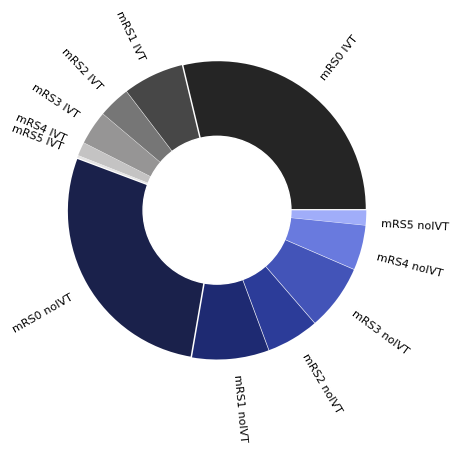

()

In [51]:
list_labels = ["mRS0 IVT", "mRS1 IVT", "mRS2 IVT", "mRS3 IVT", "mRS4 IVT", 
        "mRS5 IVT", "mRS0 noIVT", "mRS1 noIVT", "mRS2 noIVT", "mRS3 noIVT", 
        "mRS4 noIVT", "mRS5 noIVT"]

# Generate html colour codes https://htmlcolorcodes.com/
list_colors = ['#252525','#474747','#767676','#969595','#C4C3C3','#E5E4E4',
        '#1A214B','#1E2A72','#2C3C99','#4354B8','#697ADE', '#A0ADF9']

create_piechart(df_prior_disability_results, list_labels, list_colors)

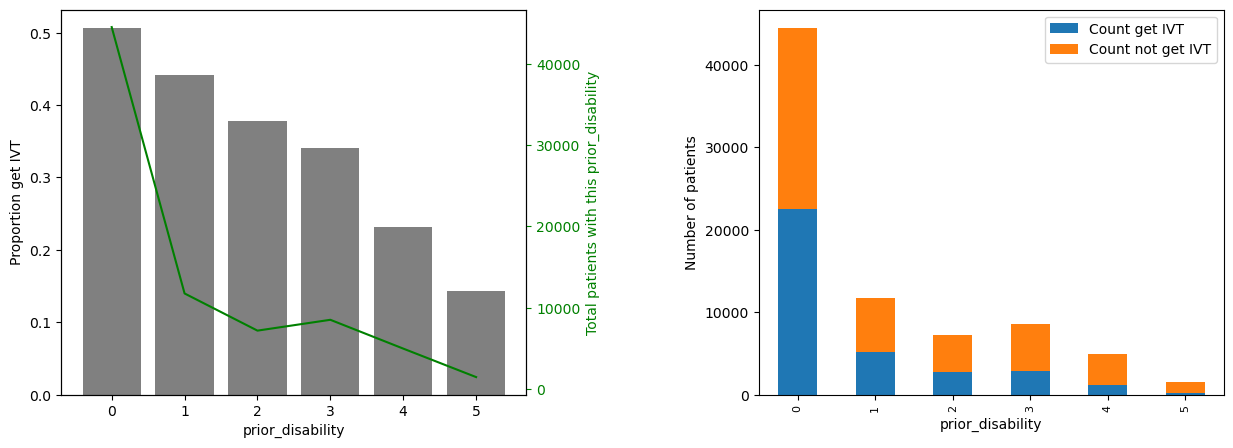

()

In [52]:
create_plots_proportion_get_thrombolysis(df_prior_disability_results, feature_name)

Show these values per hospital (as a stacked barchart): Proportion of each prior disability category to get thrombolysis

Display as stacked barplot
https://stackoverflow.com/questions/34917727/stacked-bar-plot-by-grouped-data-with-pandas

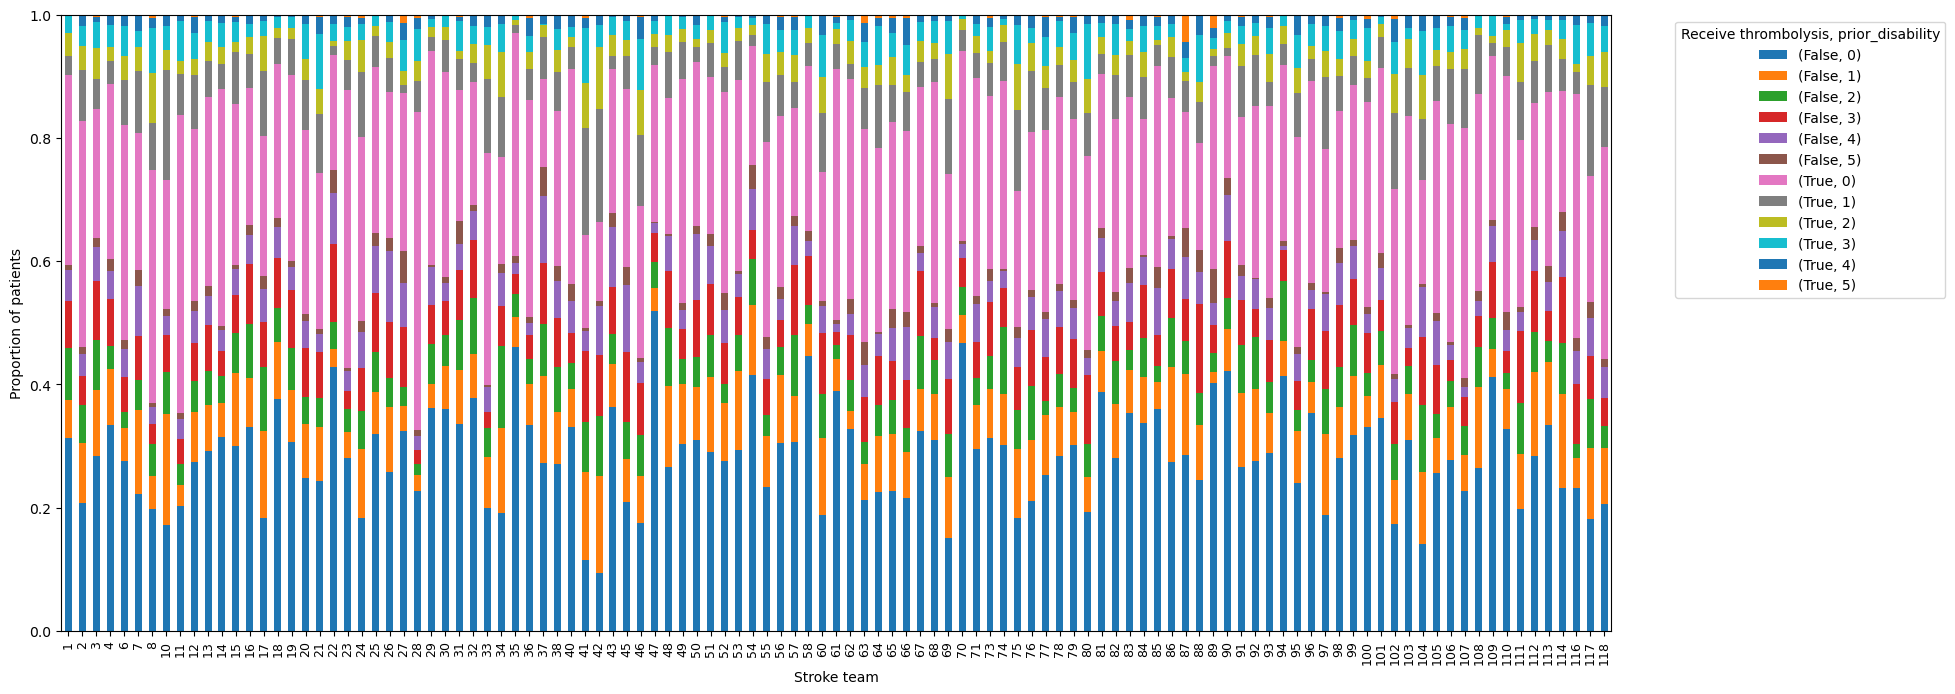

()

In [53]:
# Groupby hospital, count the number of patients with each prior disability and 
# whether receive thrombolysis
cols_by = ["stroke_team", feature_name, "Thrombolysis"]
df_subdata_groupby = df_subdata.groupby(by=cols_by).size().unstack().unstack()

# Represent values as proportions (per hospital)
df_to_plot = df_subdata_groupby.div(df_subdata_groupby.sum(axis=1), axis=0)

# Show in stacked barplot
create_stacked_barplot_by_hospital(df_to_plot, feature_name)

### Feature 2. Group patients by discharge disability

In [54]:
feature_name = "discharge_disability"

In [55]:
df_discharge_disability_results = create_groupby_dataframe(df_subdata, 
                                                           feature_name)
df_discharge_disability_results

,Total patients,Count get IVT,Count not get IVT,Proportion get IVT
discharge_disability,,,,
0.0,11152,5102,6050,0.457496
1.0,16509,7190,9319,0.435520
2.0,13903,6448,7455,0.463785
3.0,12010,5462,6548,0.454788
4.0,9423,4015,5408,0.426085
5.0,4836,1750,3086,0.361869
6.0,10563,4748,5815,0.449494


Display as piechart

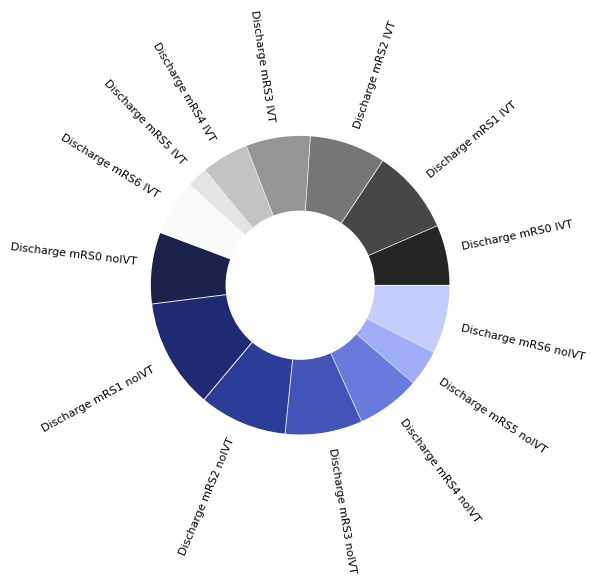

()

In [56]:
list_labels = ["Discharge mRS0 IVT", "Discharge mRS1 IVT", "Discharge mRS2 IVT", 
           "Discharge mRS3 IVT", "Discharge mRS4 IVT", "Discharge mRS5 IVT", 
           "Discharge mRS6 IVT", 
           "Discharge mRS0 noIVT", "Discharge mRS1 noIVT", 
           "Discharge mRS2 noIVT", "Discharge mRS3 noIVT", 
           "Discharge mRS4 noIVT", "Discharge mRS5 noIVT", 
           "Discharge mRS6 noIVT"]

# Generate html colour codes https://htmlcolorcodes.com/
list_colors = ['#252525','#474747','#767676','#969595','#C4C3C3','#E5E4E4', 
          '#FAFAFA', '#1A214B','#1E2A72','#2C3C99','#4354B8','#697ADE', 
          '#A0ADF9','#C5CDFC']

create_piechart(df_discharge_disability_results, list_labels, list_colors)

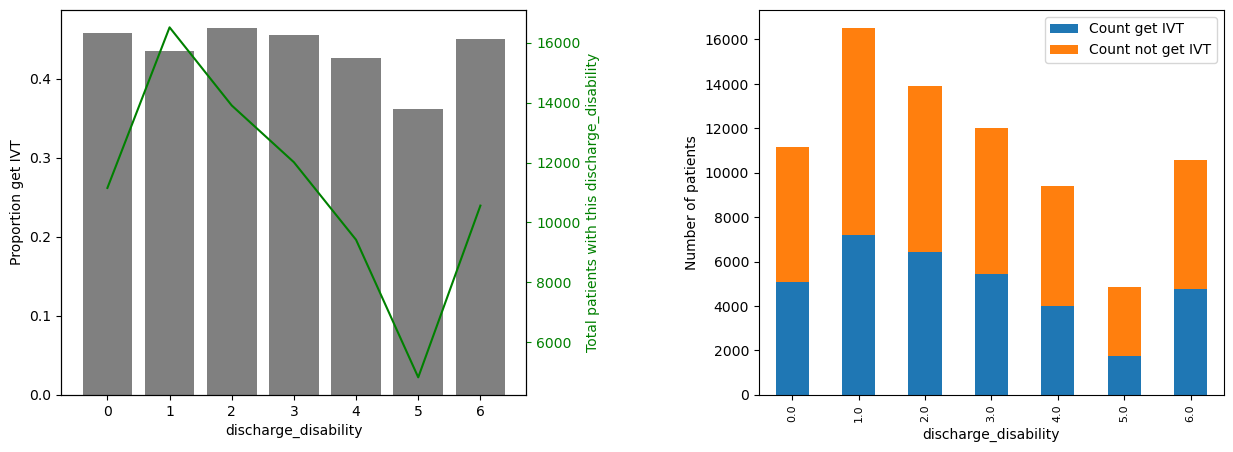

()

In [57]:
create_plots_proportion_get_thrombolysis(df_discharge_disability_results, feature_name)

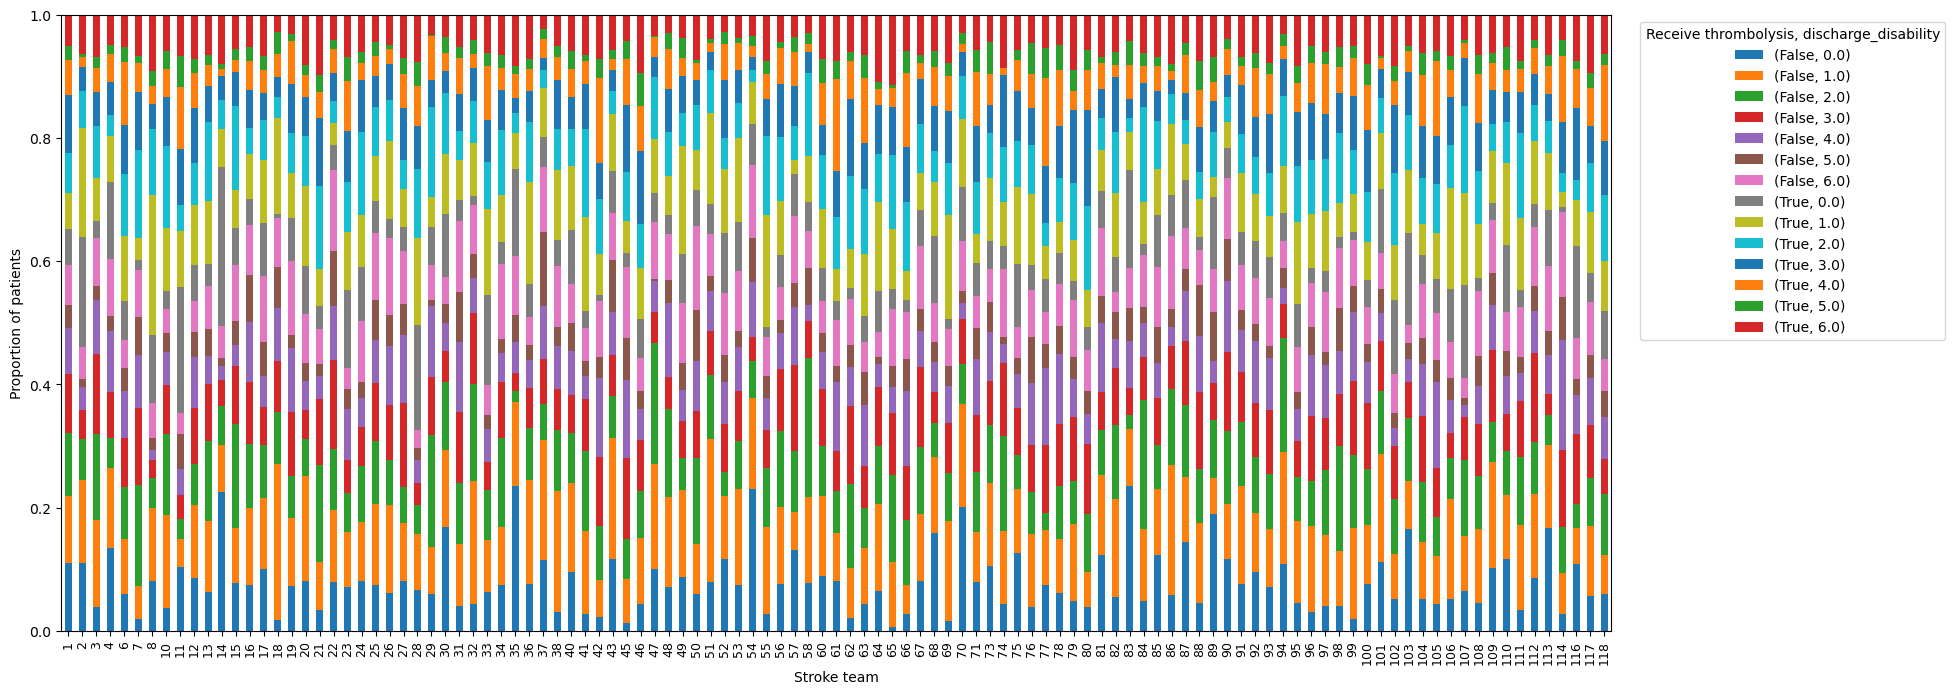

()

In [58]:
# Groupby hospital, count the number of patients with each prior disability and 
# whether receive thrombolysis
cols_by = ["stroke_team", feature_name, "Thrombolysis"]
df_subdata_groupby = df_subdata.groupby(by=cols_by).size().unstack().unstack()

# Represent values as proportions (per hospital)
df_to_plot = df_subdata_groupby.div(df_subdata_groupby.sum(axis=1), axis=0)

# Show in stacked barplot
create_stacked_barplot_by_hospital(df_to_plot, feature_name)

### Feature 3. Group patients by stroke severity

In [59]:
feature_name = "stroke_severity"

In [60]:
df_stroke_severity_results = create_groupby_dataframe(df_subdata, 
                                                      feature_name)
df_stroke_severity_results

,Total patients,Count get IVT,Count not get IVT,Proportion get IVT
stroke_severity,,,,
0,3553,154,3399,0.043344
1,5433,361,5072,0.066446
2,7484,1054,6430,0.140834
3,7181,1736,5445,0.241749
4,6336,2695,3641,0.425347
5,5624,2984,2640,0.530583
6,4878,2861,2017,0.586511
7,3882,2335,1547,0.601494
8,3297,2056,1241,0.623597


Proportion of each patient group get IVT

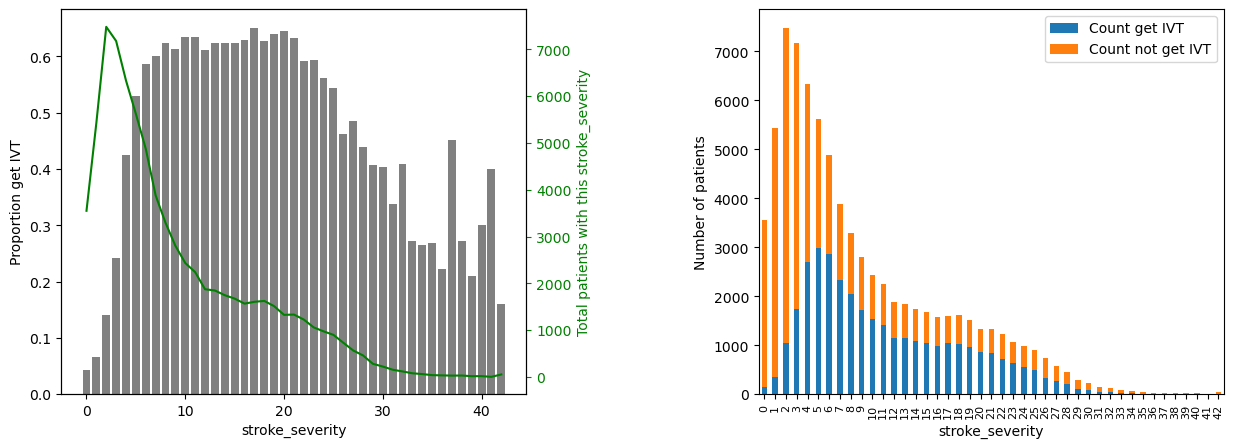

()

In [61]:
create_plots_proportion_get_thrombolysis(df_stroke_severity_results, feature_name)

In [105]:
mask_ivt = data["onset_to_thrombolysis_time"] != surrogate_time_for_no_thrombolysis
mask_not_ivt = data["onset_to_thrombolysis_time"] == surrogate_time_for_no_thrombolysis
mask_not_mt = data["thrombectomy"] == 0

mask_ivt_not_mt = mask_ivt * mask_not_mt
mask_not_ivt_not_mt = mask_not_ivt * mask_not_mt

print(f"Of the population: {data.shape[0]}")
print(f"Receive IVT (not MT): {(mask_ivt_not_mt).sum()}")
print(f"Not receive IVT (not MT): {(mask_not_ivt_not_mt).sum()}")

Of the population: 78396
Receive IVT (not MT): 32497
Not receive IVT (not MT): 43152


In [106]:
df_mrs_dist_not_ivt = data[mask_not_ivt_not_mt].groupby(by=["discharge_disability"])["discharge_disability"].count()/mask_not_ivt_not_mt.sum()*100
df_mrs_dist_not_ivt

discharge_disability
0.0    13.929829
1.0    21.408046
2.0    17.081479
3.0    14.968020
4.0    12.391083
5.0     7.074991
6.0    13.146552
Name: discharge_disability, dtype: float64

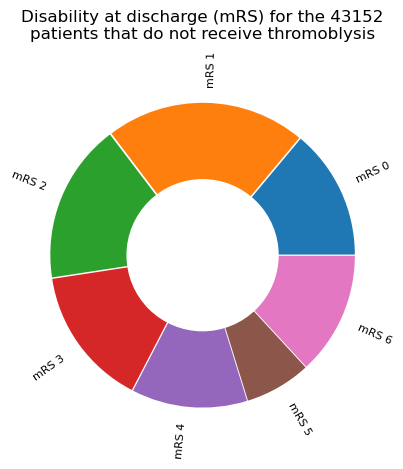

In [107]:
labels = list(df_mrs_dist_not_ivt.index.values.astype(int))
labels = ["mRS " + str(m) for m in labels]
myexplode = [0.01] * len(labels)

# plot the piechart
plt.pie(list(df_mrs_dist_not_ivt.values), labels=labels, 
        explode=myexplode, 
        rotatelabels = 270, textprops={'fontsize': 8})

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
p.gca().set_title(f"Disability at discharge (mRS) for the {mask_not_ivt_not_mt.sum()}\npatients that do not receive thromoblysis", pad=20)
p.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_mrs_distribution_pie_no_ivt.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

In [108]:
df_mrs_dist_ivt = data[mask_ivt_not_mt].groupby(by=["discharge_disability"])["discharge_disability"].count()/mask_ivt_not_mt.sum()*100
df_mrs_dist_ivt 

discharge_disability
0.0    14.832138
1.0    20.940394
2.0    18.481706
3.0    15.681448
4.0    11.573376
5.0     5.052774
6.0    13.438164
Name: discharge_disability, dtype: float64

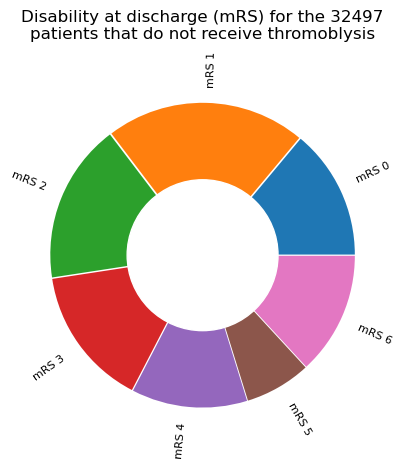

In [109]:
labels = list(df_mrs_dist_ivt.index.values.astype(int))
labels = ["mRS " + str(m) for m in labels]
myexplode = [0.01] * len(labels)

# plot the piechart
plt.pie(list(df_mrs_dist_not_ivt.values), labels=labels, 
        explode=myexplode, 
        rotatelabels = 270, textprops={'fontsize': 8})

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.5, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)
p.gca().set_title(f"Disability at discharge (mRS) for the {mask_ivt_not_mt.sum()}\npatients that do not receive thromoblysis", pad=20)
p.tight_layout()

filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_mrs_distribution_pie_get_ivt.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

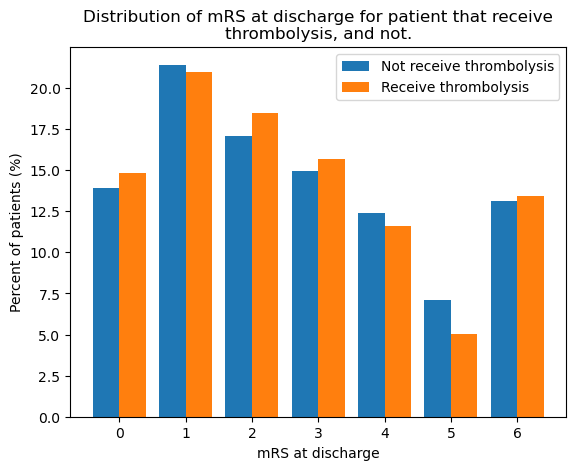

In [113]:
X_axis = df_mrs_dist_not_ivt.index.values.astype(int)
  
plt.bar(X_axis - 0.2, list(df_mrs_dist_not_ivt.values), 0.4, label='Not receive thrombolysis') 
plt.bar(X_axis + 0.2, list(df_mrs_dist_ivt.values), 0.4, label='Receive thrombolysis') 
  
#plt.xticks(X_axis, X) 
plt.xlabel("mRS at discharge") 
plt.ylabel("Percent of patients (%)") 
plt.title("Distribution of mRS at discharge for patient that receive\nthrombolysis, and not.") 
plt.legend(loc='upper right')


filename = os.path.join(paths.image_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_mrs_distribution_wrt_ivt.jpg'))

plt.savefig(filename, dpi=300)

plt.show()
